## Create Shoreline Boundary

Shoreline shapelfile data is sourced from [Geodata.gov.gr](https://geodata.gov.gr/en/dataset/aktogramme/resource/1ba9f74e-eb7a-4d0d-8858-864218806dbc).  This data is filtered for relevant islands and converted to a usable projection before being exported for use in data image sourcing.

***Why use these shapefiles?***

The goal is to source relevant, high resolution, small scale images covering the areas of interest. For the purposes of this project, an island.  Islands are oddly shaped and often do not conform to a grid-like search well.  The shoreline can be used to limit the amount of 'blue space' captured when searching gridwise over the map and capturing images.

In [1]:
import geopandas as gp
import geemap

import shapely
from shapely.geometry import Point, Polygon, MultiPolygon, collection
import fiona
from shapely.ops import polygonize

In [2]:
# Read in Coastline Data
# Cite: https://geopandas.org/en/stable/docs/user_guide/io.html
coastlines_shp = gp.read_file('../data/raw_data/aktogrammh/aktogrammh.shp')

In [3]:
type(coastlines_shp)

geopandas.geodataframe.GeoDataFrame

In [4]:
coastlines_shp['TYPE'].value_counts()

AKTH      5234
KRATOS     218
Name: TYPE, dtype: int64

In [5]:
coastlines_shp = coastlines_shp[coastlines_shp['TYPE'] == 'AKTH']

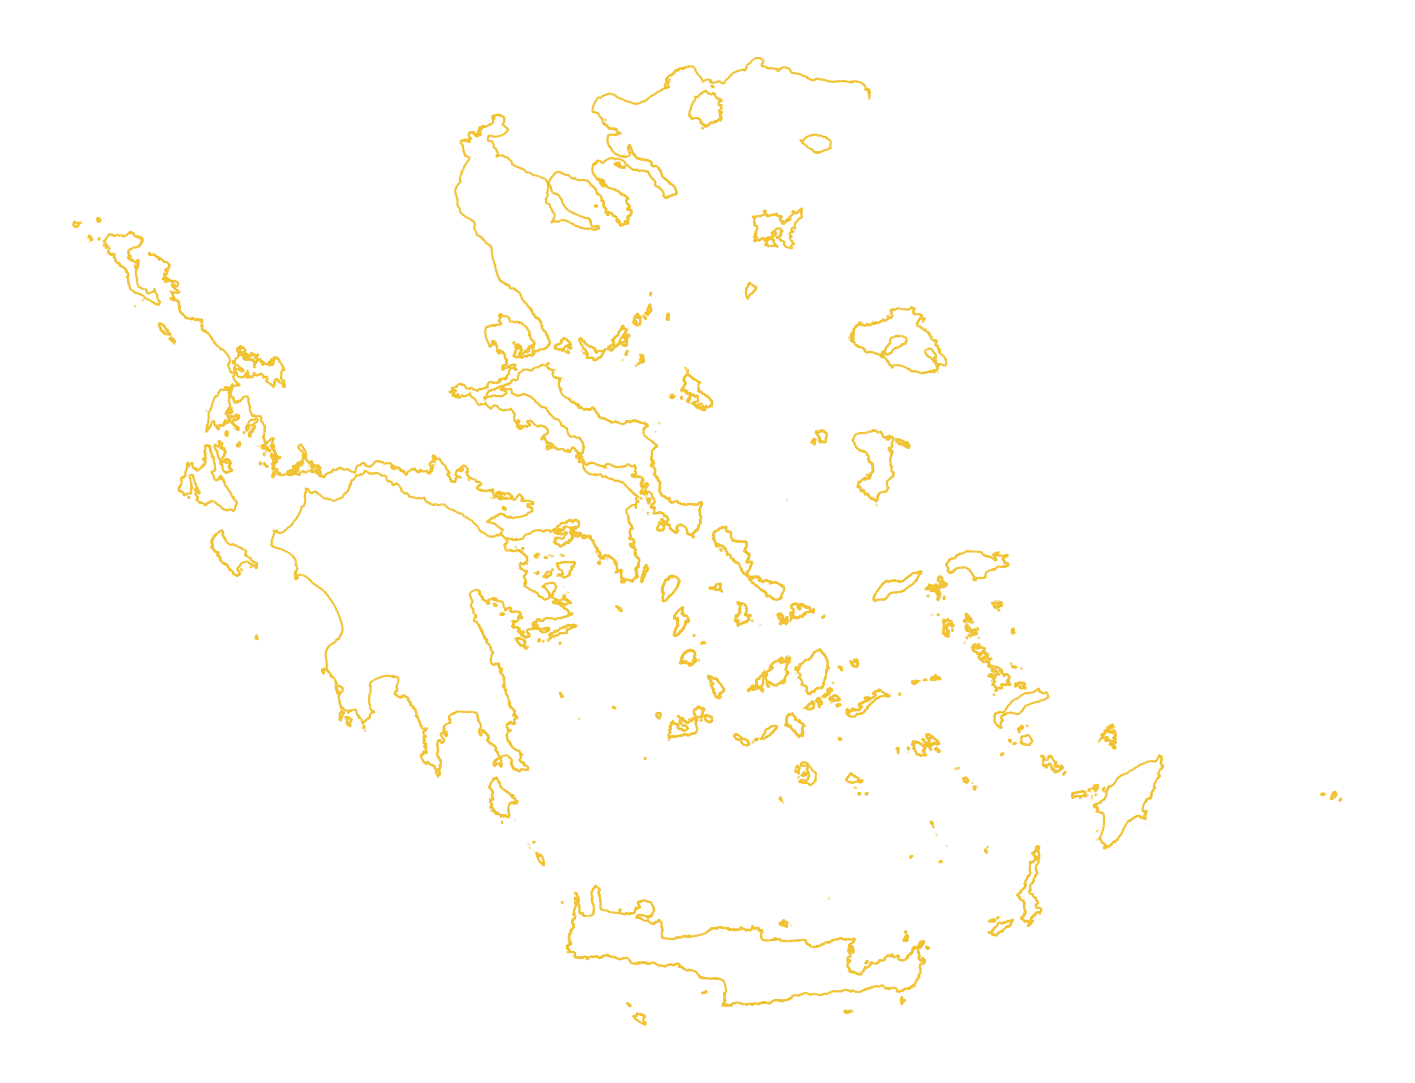

In [74]:
coastlines_shp.plot(figsize = (18,18), color = '#f1c232')
plt.axis('off');
plt.savefig(fname = '../images/greek_coastline.png')
# We are interested first in the island of Corfu (anglicized) shaped like a chili pepper at the top left of the shape file

In [7]:
coastlines_shp[round(coastlines_shp['LENGTH']) == 5274]
#Searching on the mapped version of this shapefile on the site, I found a unique distance around Barbati on Corfu.  We want the shapes connected to this one.
#Unfortunately, these files do not have identifiers for individual islands.  We will need to parse the geopandas objects out by what the continuous points contain.

,LENGTH,TYPE,geometry
2016,5273.587,AKTH,"LINESTRING (143078.750 4402332.999, 143068.500..."


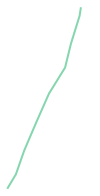

In [8]:
coastlines_shp['geometry'].values[2016]

In [9]:
coastlines_shp.shape

(5234, 3)

### Convert Lines to Polygons

In [10]:
# Cite: usage of polygonize: https://stackoverflow.com/questions/68312843/how-to-create-polygons-from-linestring-unsorted-list
polygons= gp.GeoSeries(polygonize(coastlines_shp['geometry']))

In [11]:
polygons.shape

(2025,)

### Identify Corfu
Corfu is the island of interest for the first iteration of this project.  It is the island which is seventh largest in Greece.
Area approach: cite Katie

In [12]:
polygons.area.sort_values(ascending = False).head(20)

91      2.133053e+10
1944    8.264618e+09
425     3.654527e+09
1791    1.636734e+09
1322    1.407683e+09
1891    8.439247e+08
691     7.805659e+08
643     5.906856e+08
1854    4.787386e+08
1758    4.770332e+08
1538    4.301743e+08
620     4.053277e+08
924     3.837499e+08
1446    3.810352e+08
1033    3.529256e+08
1412    3.009094e+08
724     3.002149e+08
213     2.881025e+08
142     2.772280e+08
1863    2.546762e+08
dtype: float64

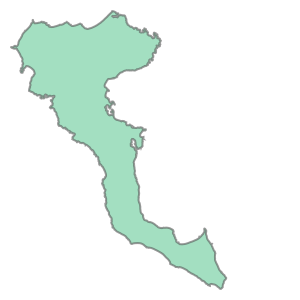

In [13]:
polygons.values[643]

In [14]:
corfu = polygons[643]

In [15]:
type(corfu)

shapely.geometry.polygon.Polygon

### Re-Project Shoreline of Island of Interest
Set up to check wether lat/long points are located inside the boundary of Corfu

In [16]:
# https://geopandas.org/en/stable/docs/user_guide/projections.html#
corfu = gp.GeoSeries(corfu, crs = 'PROJCS["Greek_Grid",GEOGCS["GCS_GGRS_1987",DATUM["D_GGRS_1987",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",24.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]')
# crs sourced from [aktogrammh.proj]

In [17]:
type(corfu)

geopandas.geoseries.GeoSeries

In [18]:
corfu.crs

<Projected CRS: EPSG:2100>
Name: GGRS87 / Greek Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Greek Geodetic Reference System 1987
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [19]:
# Re-project the original CRS to a convention which is compatible with long/lat
#cite: https://gis.stackexchange.com/a/412821
corfu = corfu.to_crs(4326)
# corfu = corfu.to_crs(3857)

#note: EPSG4326 is the most common, while folium (the library used to extract satelite imagery) defaults to EPSG3857

In [20]:
corfu.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
type(corfu)

geopandas.geoseries.GeoSeries

In [48]:
corfu

0    POLYGON ((19.68731 39.79651, 19.68751 39.79655...
dtype: geometry

In [22]:
point = shapely.geometry.Point(20.1109, 39.3642)

In [23]:
type(point)

shapely.geometry.point.Point

In [24]:
corfu.contains(point)

0    True
dtype: bool

In [25]:
# Save Coastline
corfu.to_file('../data/clean_data/coastlines/corfu.shp')

In [26]:
corfu.head()

0    POLYGON ((19.68731 39.79651, 19.68751 39.79655...
dtype: geometry

---
## Create District Boundaries

The island of Corfu (Kerkyra) covers 610 sq. kilometers and is home to over 100k people year round.  Helping to narrow down the search for a specific building is key to the success of the project and usefulness to end users.  Ideally, town boundaries would be available.  Here Municipalitity boundaries are publicly available and used.

Municipality Boundaries as defined by the Kapodistrias plan.
Source: [geodata.gov.gr](https://geodata.gov.gr/en/dataset/oria-demon-kapodistriakoi)

In [32]:
munis = gp.read_file('../data/raw_data/oria_kapodistriakwn_dhmwn/oria_kapodistriakwn_dhmwn.shp', encoding = 'cp1253')

In [33]:
munis_c = munis[munis['PREF_ID'].astype(int) == 22]

In [34]:
munis_c.head(10)

,ESYE_ID,GREEKNAME,PREF_ID,PREFECTURE,EDRA,geometry
970,22080000,ΛΕΥΚΙΜΜΑΙΩΝ,22,Ν. ΚΕΡΚΥΡΑΣ,ΛΕΥΚΙΜΜΗ,"POLYGON ((164046.929 4368395.712, 164445.390 4..."
971,22110000,ΠΑΞΩΝ,22,Ν. ΚΕΡΚΥΡΑΣ,ΠΑΞΟΙ,"MULTIPOLYGON (((176155.500 4336408.999, 175996..."
1007,22010000,ΚΕΡΚΥΡΑΙΩΝ,22,Ν. ΚΕΡΚΥΡΑΣ,ΚΕΡΚΥΡΑ,"MULTIPOLYGON (((149273.776 4389464.397, 149253..."
1008,22020000,ΑΓΙΟΥ ΓΕΩΡΓΙΟΥ,22,Ν. ΚΕΡΚΥΡΑΣ,ΑΓΡΟΣ,"MULTIPOLYGON (((125786.525 4405938.124, 125757..."
1009,22030000,ΑΧΙΛΛΕΙΩΝ,22,Ν. ΚΕΡΚΥΡΑΣ,ΓΑΣΤΟΥΡΙ,"POLYGON ((144941.326 4390912.498, 144968.657 4..."
1010,22040000,ΕΣΠΕΡΙΩΝ,22,Ν. ΚΕΡΚΥΡΑΣ,ΒΕΛΟΝΑΔΕΣ,"MULTIPOLYGON (((131124.645 4414086.870, 131129..."
1011,22050000,ΘΙΝΑΛΙΟΥ,22,Ν. ΚΕΡΚΥΡΑΣ,ΑΧΑΡΑΒΗ,"POLYGON ((144631.765 4414883.757, 144746.065 4..."
1012,22060000,ΚΑΣΣΩΠΑΙΩΝ,22,Ν. ΚΕΡΚΥΡΑΣ,ΚΑΣΣΙΟΠΗ,"MULTIPOLYGON (((153849.866 4412238.589, 153843..."
1013,22070000,ΚΟΡΙΣΣΙΩΝ,22,Ν. ΚΕΡΚΥΡΑΣ,ΑΡΓΥΡΑΔΕΣ,"POLYGON ((153126.495 4375316.432, 153457.488 4..."
1014,22090000,ΜΕΛΙΤΕΙΕΩΝ,22,Ν. ΚΕΡΚΥΡΑΣ,ΜΟΡΑΙΤΙΚΑ,"MULTIPOLYGON (((142465.247 4384090.417, 142459..."


In [53]:
munis_c.shape

(16, 6)

### Further Opportunity - Translate Greek Text to Anglicized Text

In [52]:
# Get translation from Greek to English Characters
# !pip install googletrans

In [33]:
# from googletrans import Translator
# translator = Translator()
# munis_c['EDRA'] = munis_c['EDRA'].map(lambda x: translator.translate(str(x)).text)

AttributeError: 'NoneType' object has no attribute 'group'

### Plot Regions

In [35]:
import matplotlib.pyplot as plt

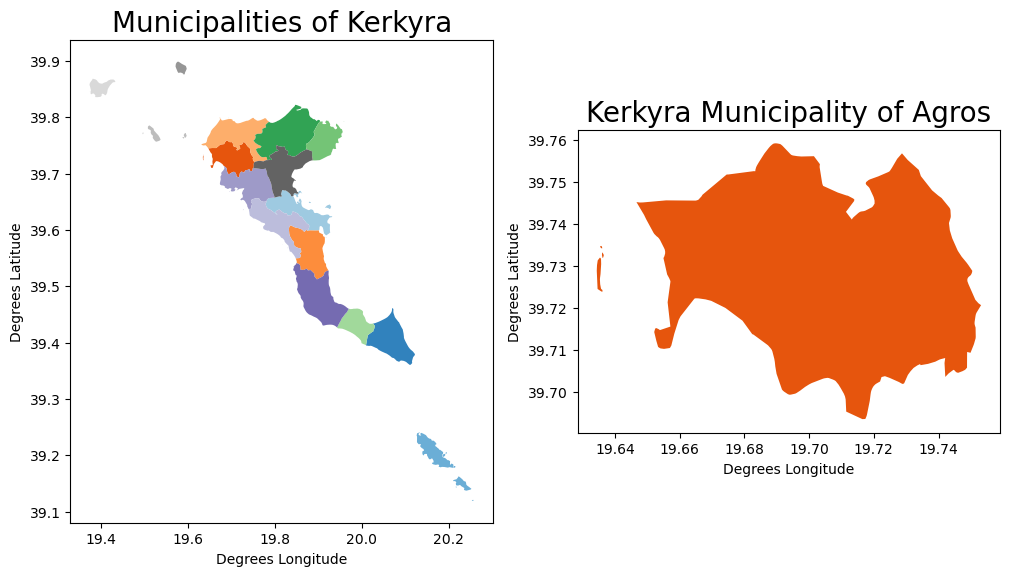

In [68]:
fig, ax = plt.subplots(1,2, figsize = (12,8))
ax[0].set_title('Municipalities of Kerkyra',size=20)
ax[0].set_xlabel('Degrees Longitude')
ax[0].set_ylabel('Degrees Latitude')
munis_c.plot(cmap = 'tab20c', ax=ax[0])
ax[1].set_title('Kerkyra Municipality of Agros', size = 20)
ax[1].set_xlabel('Degrees Longitude')
ax[1].set_ylabel('Degrees Latitude')
munis_c[munis_c['EDRA'] == 'ΑΓΡΟΣ'].plot(color = '#e6550d', ax=ax[1]);
plt.savefig('../images/geo_boundaries',dpi=200)

Focusing on Agros (ΑΓΡΟΣ)

In [37]:
munis_c[munis_c['EDRA'] == 'ΑΓΡΟΣ']

,ESYE_ID,GREEKNAME,PREF_ID,PREFECTURE,EDRA,geometry
1008,22020000,ΑΓΙΟΥ ΓΕΩΡΓΙΟΥ,22,Ν. ΚΕΡΚΥΡΑΣ,ΑΓΡΟΣ,"MULTIPOLYGON (((125786.525 4405938.124, 125757..."


In [38]:
#Projection needs to be adjusted, similar to the above map of Corfu's outline
munis_c = gp.GeoDataFrame(munis_c, geometry = 'geometry', 
                          crs='PROJCS["Greek_Grid",GEOGCS["GCS_GGRS_1987",DATUM["D_GGRS_1987",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",24.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]')

In [39]:
munis_c.crs

<Projected CRS: EPSG:2100>
Name: GGRS87 / Greek Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Greece - onshore.
- bounds: (19.57, 34.88, 28.3, 41.75)
Coordinate Operation:
- name: Greek Grid
- method: Transverse Mercator
Datum: Greek Geodetic Reference System 1987
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [40]:
munis_c = munis_c.to_crs(4326)

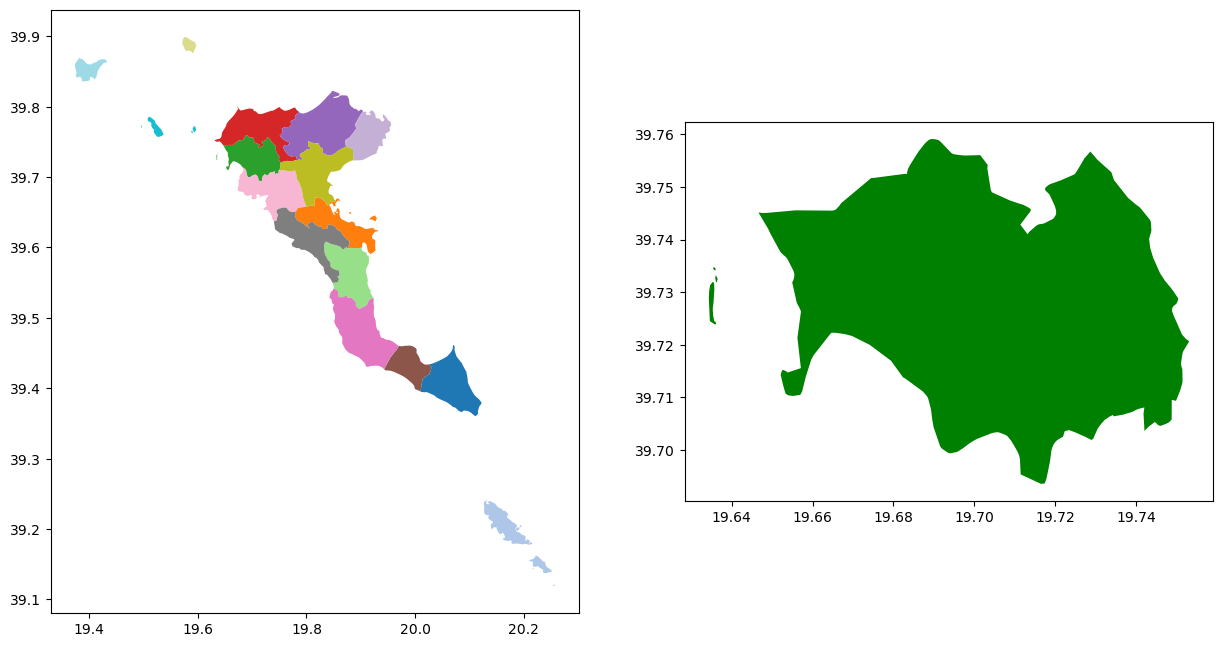

In [41]:
fig, ax = plt.subplots(1,2, figsize = (15,10))
munis_c.plot(cmap = 'tab20', ax=ax[0])
munis_c[munis_c['EDRA'] == 'ΑΓΡΟΣ'].plot(color = 'green', ax=ax[1]);

In [42]:
point = shapely.geometry.Point(19.686689, 39.722445)

In [43]:
munis_c.loc[munis_c['EDRA'] == 'ΑΓΡΟΣ', 'geometry'].contains(point)
#success!

1008    True
dtype: bool

In [44]:
agros = munis_c['geometry'][munis_c['EDRA'] == 'ΑΓΡΟΣ']

In [49]:
agros.contains(point)

1008    True
dtype: bool

In [47]:
# Save Municipality Boundary
agros.to_file('../data/clean_data/coastlines/agros.shp')